## Kalman Filter Associative Learning Paradigms

### kalman.py documentation

`KalmanFilter()` object 
* arguments:

    * `d_in` : $x_n \in R^{d_{in}}$ number of conditioned stimuli (no default)
    * `var_w` : $\sigma_w^2$ initial weight variance (default $1$)
    * `var_r` : $\sigma_r^2$ initial reward variance (default $1$)
    * `volatility` : $\tau^2$ diffusion constant (default $0.01$)
    * `rate` : learning rate $\eta$ for $\tau^2$ and $\sigma^2$ in the extended model (default is 0 $\implies$ no updates).

* methods:
    * `update(x, reward)` : updates parameters when observation of `x` stimulus vector followed by `reward`
    * `zero()` : forget everything it learned
    * `train(x, reward, nepochs=10)` : `nepochs` trials of `update(x, reward)`
    

### How $\sigma_r^2$ and $\tau^2$ fit into Kalman Filter model

* $\sigma_r^2$ reflects how noisy you believe the underlying reward emission distribution $p(r_n|v_n)$ is. Higher $\sigma_r^2$ means you believe $v_n$ is not as good a predictor of the reward. The amount you learn (as measured by the magnitude of the learning rate) is inversely related to $\sigma_r^2$. 

* Essentially, if you believe the reward distribution is inherently noisy, each cue association has less meaning to you. 

* Learning rate is higher/lower when $\sigma_r^2$ is lower/higher.

* $\tau^2$ reflects how noisy you believe the state transitions $p(w_n | w_{n - 1})$ are. Higher $\tau^2$ means that you believe the world is changing pretty quickly, so you should learn new associations more quickly. 

* So learning rate is higher/lower when $\tau^2$ is higher/lower.

* These parameters represent an agent's theory about the state of the world's dynamics.
 

   

### MLL gradient update rules for $\sigma_r^2$ and $\tau^2$

* Rules:

    * $\sigma_r^2 := \sigma_r^2 + \eta \Delta \sigma_r^2$
    
    * $\tau^2 := \tau^2 + \eta \Delta \tau^2$

    * $\Delta \sigma_r^2 = \frac{1}{2 \sigma_r^2} \left(\frac{\delta_n^2}{\sigma_r^2} - 1\right)$

    * $\Delta \tau^2 = \frac{1}{2 \tau^2} \left(\frac{|w_n - w_{n - 1}|^2}{\tau^2} - d_{in}\right)$
    
    * $\eta$ is just a learning rate for these parameters
    
* Intuition:

    * Change in a variance parameter is proportional to the product of the reciprocal variance and the observed "relative error" in the variance parameter.
    
    * Key point:
    
        * $\delta_n^2$ is a single point estimate of $\sigma_r^2$ in that $\mathbb{E}[\delta_n^2] = \sigma_r^2$ if $\sigma_r^2$ is correct. 
    
        * $\frac{|w_n - w_{n - 1}|}{d_{in}}^2$ is a single point estimate of $\tau^2$ in that $\mathbb{E}[|w_n - w_{n - 1}|^2] = d_{in}\tau^2$ if $\tau^2$ is correct.
        
    * If the single point estimate of the variance exceeds your overall estimate of the variance, you should increase your estimate. If your single point estimate of the variance is less than your overall estimate of the variance, you should decrease your estimate. If they are equal there's nothing to learn.
      

### Why we care:

* Modulates learning rate based on outcomes.
    
* $\tau^2$ and $\sigma_r^2$ represent beliefs about the dynamics of the world, which should be updated when confronted with new data. These updates allow me to both understand what the world is like and update my understanding when the world changes.
    
* My preliminary observations: 
    * $\eta = 0.1$ is an OK value. 
    
    * Latent inhibition lasts for shorter periods of time. This makes sense because once you understand that the world has changed, you throw out old beliefs and acquire new knowledge more quickly.
    
    * In general learning seems to be faster and more adaptable to changes.
    
    * Recovery phenomenon are faster as well. Same underlying principle.
    
    * There are probably errors in my implementation, so we should test it extensively.

### Single CS Setup

In [3]:
%matplotlib inline
from kalman import KalmanFilter
import numpy as np

KF = KalmanFilter(1,
                var_w=1,
                var_r=1,
                volatility=0.01,
                rate=0)
A = np.array([1])

### Basic Association $A \rightarrow +; A \rightarrow ?$

Response to A: 1.000


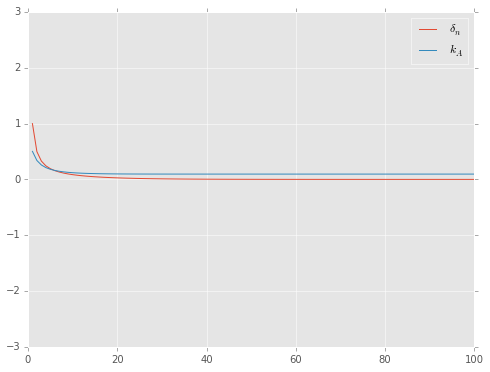

0.01

In [4]:
KF.train(A, 1, nepochs=100)
    
print "Response to A: %.3f" % KF.predict(A)
KF.plot()
KF.var_r
KF.volatility

### Latent Inhibition $A \rightarrow - ; A \rightarrow +; A \rightarrow ?$ (updating $\tau, \sigma_r$ reduces this)

Response to A w/o preconditioning: 0.925
Response to A w/ preconditioning: 0.668


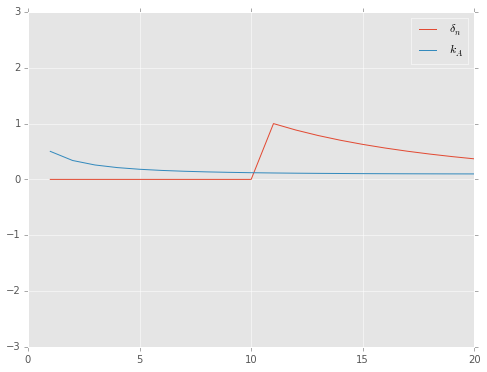

In [5]:
KF.zero()
KF.train(A, 1, nepochs=10)

print ("Response to A w/o preconditioning: %.3f" % KF.predict(A))

KF.zero()
KF.train(A, 0, nepochs=10)
KF.train(A, 1, nepochs=10)

print ("Response to A w/ preconditioning: %.3f" % KF.predict(A))
KF.plot()

### Two CS setup

In [6]:
KF = KalmanFilter(2, var_w=1, var_r=1, volatility=0.01, rate=0)

A = np.array([1, 0])
B = np.array([0, 1])
AB = np.array([1, 1])

### Overshadowing Extinction $AB \rightarrow +; A \rightarrow -; A \rightarrow ?$

Response to B after overshadowing w/o A extinction: 0.483
Response to B after overshadowing w/ A extinction: 0.826


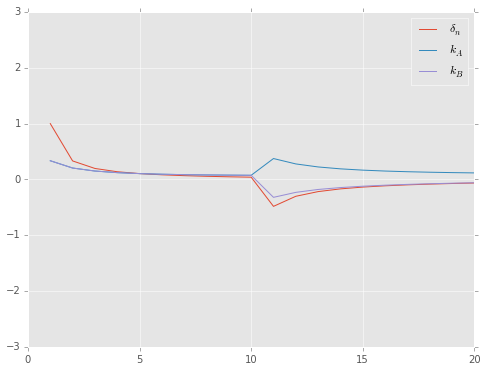

In [7]:
KF.zero()
KF.train(AB, 1, nepochs=10)

print "Response to B after overshadowing w/o A extinction: %.3f" % KF.predict(B)

KF.zero()

KF.train(AB, 1, nepochs=10)

KF.train(A, 0, nepochs=10)
    
print "Response to B after overshadowing w/ A extinction: %.3f" % KF.predict(B)
KF.plot()

### Forward Blocking Extinction $A \rightarrow +; AB \rightarrow +; A \rightarrow -; B \rightarrow ?$

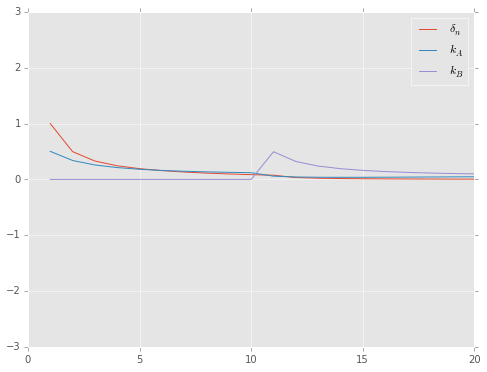

Response to B w/o A extinction 0.062


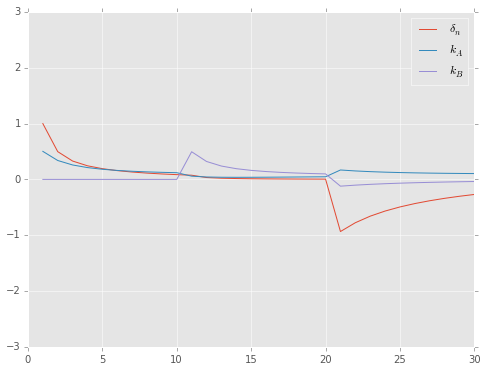

Response to B w/ A extinction 0.476


In [10]:
KF.zero()
KF.train(A, 1, nepochs=10)
KF.train(AB, 1, nepochs=10)
KF.plot()
print "Response to B w/o A extinction %.3f" % KF.predict(B)

KF.zero()
KF.train(A, 1, nepochs=10)
KF.train(AB, 1, nepochs=10)
KF.train(A, 0, nepochs=10)
KF.plot()
print "Response to B w/ A extinction %.3f" % KF.predict(B)

### TODO : Add More Basic Paradigms, Create Paradigms KF fails at but KF++ doesn't fail at

### Sensory Preconditioning $AB \rightarrow -; A \rightarrow +; B \rightarrow -$

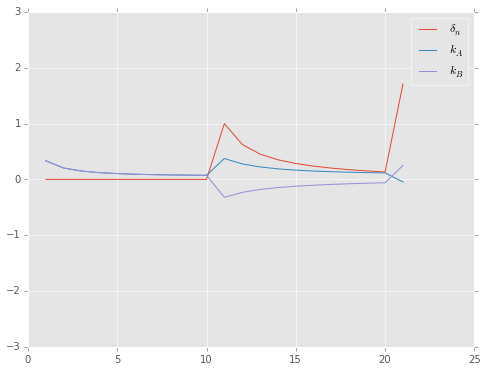

Response to B w/ preconditioning -0.283


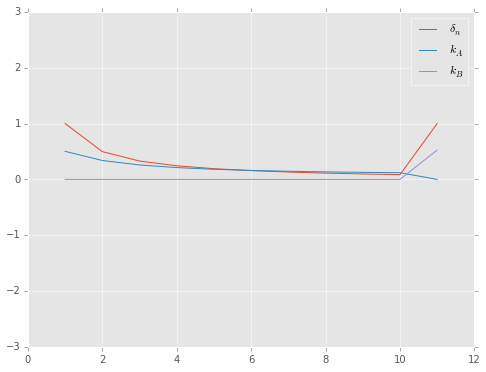

Response to B w/o preconditioning 0.526


In [11]:
KF.zero()
KF.train(AB, 0, nepochs=10)
KF.train(A, 1, nepochs=10)
KF.train(B, 1, nepochs=1)
KF.plot()
print "Response to B w/ preconditioning %.3f" % KF.predict(B)

KF.zero()
KF.train(A, 1, nepochs=10)
KF.train(B, 1, nepochs=1)
KF.plot()
print "Response to B w/o preconditioning %.3f" % KF.predict(B)

### Simple Reversal Training $A \rightarrow -; A \rightarrow +$

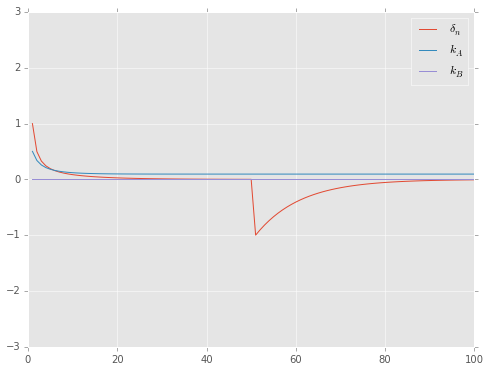

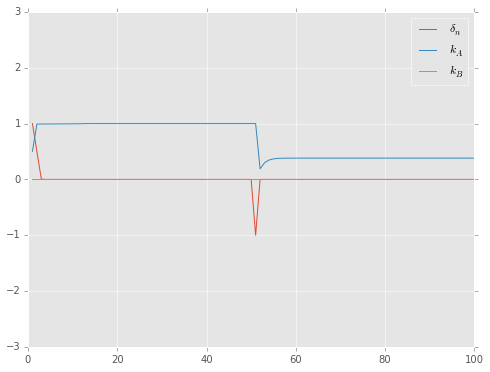

In [23]:
KF = KalmanFilter(2, var_w=1, var_r=1, volatility=0.01, rate=0)
KF.zero()
KF.train(A, 1, nepochs=50)
KF.train(A, 0, nepochs=50)
KF.plot()

KF = KalmanFilter(2, var_w=1, var_r=1, volatility=0.01, rate=0.1)
KF.zero()
KF.train(A, 1, nepochs=50)
KF.train(A, 0, nepochs=50)
KF.plot()

### Complex Reversal Training $A \rightarrow + \ with \ B \rightarrow -; A \rightarrow - \ with \ B \rightarrow +$

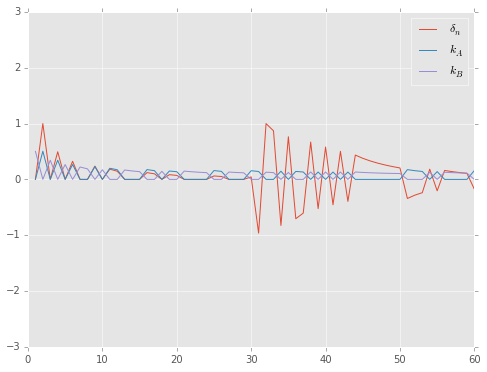

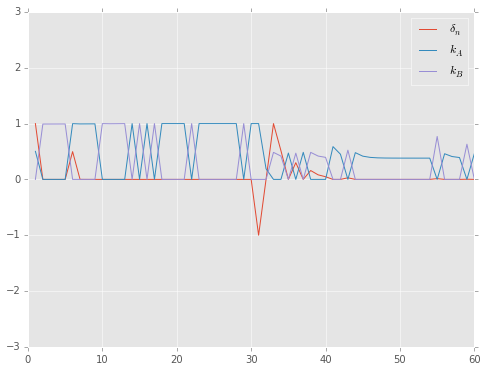

In [26]:
KF = KalmanFilter(2, var_w=1, var_r=1, volatility=0.01, rate=0)
KF.zero()
for _ in range(30):
  if np.random.random() < 0.5:
    KF.train(A, 1, nepochs=1)
  else:
    KF.train(B, 0, nepochs=1)
    
for _ in range(30):
  if np.random.random() < 0.5:
    KF.train(B, 1, nepochs=1)
  else:
    KF.train(A, 0, nepochs=1)

KF.plot()

KF = KalmanFilter(2, var_w=1, var_r=1, volatility=0.01, rate=0.1)
KF.zero()
for _ in range(30):
  if np.random.random() < 0.5:
    KF.train(A, 1, nepochs=1)
  else:
    KF.train(B, 0, nepochs=1)
    
for _ in range(30):
  if np.random.random() < 0.5:
    KF.train(B, 1, nepochs=1)
  else:
    KF.train(A, 0, nepochs=1)

KF.plot()